In [3]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import json
from sqlalchemy import Connection, select
from tabDatabase import *
from shortname import short_school_name, chapter_code
from collections import Counter, defaultdict
import re
import itertools

total_entries = 615613
caselist_total = 338521
metadata.create_all(tabEngine)
pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", 20)
tqdm.pandas()

In [2]:
%reload_ext autoreload
%reload_ext line_profiler
%autoreload

# Find Team Names

In [4]:
def getSections(entry_name: str) -> list[str]:
    if ' - ' in entry_name and ' and ' in entry_name: # Some were formatted like this before 2015-2016 season
        entry_name = entry_name.split(' - ')[1]
    sections = re.split(r', | & | and ', entry_name) 
    return [s.strip() for s in sections if s.strip()] # Filter out empty and trim

In [5]:
getShortName = lambda s: re.sub(r'[^a-zA-Z]', '', s)[0:2].capitalize()
def parseTeamName(entry_name: str) -> tuple[str, str]:
    sections = getSections(entry_name)
    if len(sections) >= 2:
        sections = sorted(sections)
        return '&'.join([getShortName(s) for s in sections]), '&'.join(sections)
    else:
        return ' '.join([getShortName(s) for s in sections[0].split(' ')]), sections[0]

In [6]:
with tabEngine.begin() as conn:
    team_entries = conn.execute(text("""
        select t.id as team_id, t.num_debaters, e.*, t2.season from entry e
            join team t on e.team = t.id
            join event e2 on e.event = e2.id
            join category c on e2.category = c.id
            join tournament t2 on c.tournament = t2.id
            where ((t.num_debaters = 1 and e.name regexp '[a-zA-Z\-'']+ [a-zA-Z\-'']+') or
                  (t.num_debaters >= 2 and e.name regexp '([a-zA-Z\-''. ]+, )*[a-zA-Z\-''. ]+ & [a-zA-Z\-''. ]+'))
                  and t2.season >= 2013;
    """))
    rows = list(tqdm(team_entries.mappings(), total=600207))

  0%|          | 0/600207 [00:00<?, ?it/s]

In [7]:
team_code_sets: defaultdict[str, set] = defaultdict(set)
team_name_sets: defaultdict[str, set] = defaultdict(set)
for row in tqdm(rows):
    team_short_name, team_full_name = parseTeamName(row['name'])
    if team_short_name: team_short_name += str(row['season'])
    if team_full_name: team_full_name += str(row['season'])

    team_code_sets[team_short_name].add(row['team_id'])
    team_name_sets[team_full_name].add(row['team_id'])

  0%|          | 0/603910 [00:00<?, ?it/s]

# Match to caselist

- Direct
    - Name from open source
    - Judge names
    - Opponent codes
    - Side+num
    - Only with name/initials
- Indirect
    - school
    - only name/initials with other matches removed

## Load Data

In [152]:
caselist_data = pd.read_feather('./data/caselist_data.feather')
caselist_data = caselist_data[caselist_data.year != 2022]
caselist_data_by_id = caselist_data.set_index('roundId', drop=True)
caselist_data['schoolShortName'] = caselist_data.schoolDisplayName.apply(lambda n: chapter_code(short_school_name(n)))
caselist_team_data = caselist_data.drop_duplicates('teamId').set_index('teamId')
caselist_data_by_team = caselist_data.set_index(['teamId', 'roundId'])

In [9]:
from typing_extensions import Self

sort_str = lambda s: ''.join(sorted(s))
opponent_codes_stmt = text("""
        select distinct any_ballot.section, opponent_entry.short_name, opponent_entry.id, r.name, r.label, team_ballot.side, t.id as tournament_id, s.id as section_id
            from team
            join entry team_entry on team.id = team_entry.team
            join ballot team_ballot on team_entry.id = team_ballot.entry
            join ballot any_ballot on team_ballot.section = any_ballot.section
            join entry opponent_entry on opponent_entry.id = any_ballot.entry
            join section s on team_ballot.section = s.id
            join event e on team_entry.event = e.id
            join category c on e.category = c.id
            join tournament t on c.tournament = t.id
            join round r on s.round = r.id
            where team.id = :team_id
                and t.season = :season
                and opponent_entry.id != team_entry.id
                and opponent_entry.short_name is not null
""")

def is_match(match_info: dict[str, int]) -> bool:
    return (match_info['judge']*2 + match_info['opponent'] + match_info['only']) >= 2

def translate_tabroom_round_name(label: str, name: int):
    if not label: return str(name)
    label = label.lower()
    # Allow things like "JV" or "Policy" at start except where leads to false matches
    if label.startswith('fin') or label.startswith('fnl') or label == 'f': return 'Finals' # Cant match things like semifinals
    if 'sem' in label or 'sf' in label or label == 's': return 'Semis'
    if 'q' in label and not 'qual' in label: return 'Quarters'
    if label.startswith('oct') or label.startswith('of'): return 'Octos' # Cant match thing like double octos
    if 'doub' in label or 'dub' in label or 'dbl' in label or '2x' in label or 'sex' in label or label.startswith('do'): return 'Doubles'
    if 'trip' in label or '3x' in label: return 'Triples'
    return str(name)

tabroom_sides = {
    1: 'A', 2: 'N'
}

In [114]:
class CaselistTeam:
    def __init__(self, caselist_id: int, rounds: pd.DataFrame = None):
        self.caselist_id = caselist_id
        try:
            self.rounds = rounds if rounds is not None else caselist_data_by_team.loc[caselist_id]
        except KeyError:
            raise ValueError(f"no rounds for the caselist team id {caselist_id}")

        self.team_data = self.rounds.iloc[0]
        self.season: int = int(self.team_data.year) # Apparently the pandas number types don't work with sqlalchemy :)

        self.caselist_single_judges = self.get_judge_data(self.rounds[self.rounds.judge.str.fullmatch(r'\w+ \w+').fillna(False)])
        self.tabroom_judges: dict[int, dict[tuple, list[list[int]]]] = {}

        self.caselist_opponent_codes = self.get_opponent_data(self.rounds[self.rounds.opponent.str.match(r'.*\s[a-zA-Z]{2}$').fillna(False)])
        self.tabroom_opponent_codes: dict[int, dict[tuple, list[list[int]]]] = {}

        self.candidate_ids = self.find_team_ids()
        self.candidate_school_names = {}

        self.total_rounds = len(self.rounds)
        self.total_judges = len(self.caselist_single_judges)
        self.total_opponents = len(self.caselist_opponent_codes)

        self.judge_matches: dict[int, int] = {}
        self.opponent_matches: dict[int, int] = {}
        self.school_matches: dict[int, bool] = {}
        self.match_probabilities: dict[int, float] = {}
        self.tabroom_id: int | None = None
        self.round_matches: dict[int: int | None] = {round_id: None for round_id in self.rounds.index}

        self.caselist_school_name = self.team_data.schoolName
        self.caselist_school_tabroom_names = set()

    def get_judge_data(self, rounds: pd.DataFrame):
        return [
            (re.sub(r'[^\s\w]', '', round_data['judge'].lower()), round_data['round'].replace('Round ', ''), round_data['side'])
            for _, round_data in rounds.iterrows()
        ]
    def get_opponent_data(self, rounds: pd.DataFrame):
        codes = []
        for _, round_data in rounds.iterrows():
            opponent_code = round_data['opponent'][-2:].upper()
            if self.team_data.teamSize > 1: opponent_code = sort_str(opponent_code)
            round_name = round_data['round'].replace('Round ', '')
            codes.append((opponent_code, round_name, round_data['side']))
        return codes

    def find_team_ids(self) -> set[int]:
        if self.team_data.teamSize == 2:
            if self.team_data.debater2Last is None: return set()
            if self.team_data.year != 2022:
                file_name_index = self.rounds.fileName.first_valid_index()
                if file_name_index:
                    file_name = self.rounds.loc[file_name_index].fileName
                    names = file_name.split('-')[1:3]
                    team_name = '&'.join(sorted(names)) + str(self.team_data.year)
                    return team_name_sets[team_name]

            names = sorted((self.team_data.debater1Last[0:2], self.team_data.debater2Last[0:2]))
            team_code = '&'.join(names) + str(self.team_data.year)
        else:
            team_code = f"{self.team_data.debater1First[0:2]} {self.team_data.debater1Last[0:2]}{self.team_data.year}"
        return team_code_sets[team_code]

    def find_judge_matches(self, tabroom_connection: Connection) -> dict[int, int]:
        match_data = {tabroom_team_id: 0 for tabroom_team_id in self.candidate_ids}
        if self.total_judges == 0: return match_data

        judge_q = select(judge_table.c.first, judge_table.c.last, ballot_table.c.section, ballot_table.c.side, entry_table.c.team, round_table.c.name, round_table.c.label, tournament_table.c.id.label('tournament_id'), section_table.c.id.label('section_id'))\
            .select_from(
                ballot_table
                    .join(judge_table, ballot_table.c.judge == judge_table.c.id)
                    .join(entry_table, ballot_table.c.entry == entry_table.c.id)
                    .join(section_table, ballot_table.c.section == section_table.c.id)
                    .join(round_table, section_table.c.round == round_table.c.id)
                    .join(category_table, judge_table.c.category == category_table.c.id)
                    .join(tournament_table, category_table.c.tournament == tournament_table.c.id)
            )\
            .where(entry_table.c.team.in_(self.candidate_ids))\
            .where(tournament_table.c.season == self.season)\
            .order_by(entry_table.c.team)

        for tabroom_team_id, ballots in itertools.groupby(tabroom_connection.execute(judge_q).mappings(), lambda x: x['team']):
            section_ballots = (list(section_ballot) for _, section_ballot in itertools.groupby(ballots, lambda x: x['section']))
            single_judge_ballots = (section_ballot[0] for section_ballot in section_ballots if len(section_ballot) == 1)
            team_judges = {}
            for ballot in single_judge_ballots:
                key = (
                    re.sub(r'[^\s\w]', '', f'{ballot["first"]} {ballot["last"]}'.lower()),
                    translate_tabroom_round_name(ballot['label'], ballot['name']),
                    tabroom_sides.get(ballot['side'], '')
                )
                if key not in team_judges: team_judges[key] = []
                team_judges[key].append([ballot['tournament_id'], ballot['section_id']])
            self.tabroom_judges[tabroom_team_id] = team_judges
            match_data[tabroom_team_id] = sum(judge in team_judges for judge in self.caselist_single_judges)
        return match_data

    def find_opponent_matches(self, tabroom_connection: Connection) -> dict[int, int]:
        match_data = {tabroom_team_id: 0 for tabroom_team_id in self.candidate_ids}
        if self.total_opponents == 0: return match_data

        for tabroom_team_id in self.candidate_ids:
            opponent_query = opponent_codes_stmt.bindparams(team_id=tabroom_team_id, season=self.season)
            team_opponent_codes = {}
            for round_data in tabroom_connection.execute(opponent_query).mappings():
                key = (
                    round_data['short_name'],
                    translate_tabroom_round_name(round_data['label'], round_data['name']),
                    tabroom_sides.get(round_data['side'], ''),
                )
                if key not in team_opponent_codes: team_opponent_codes[key] = []
                team_opponent_codes[key].append([round_data['tournament_id'], round_data['section_id']])
            self.tabroom_opponent_codes[tabroom_team_id] = team_opponent_codes
            match_data[tabroom_team_id] = sum(opponent in team_opponent_codes for opponent in self.caselist_opponent_codes)
        return match_data

    def find_school_matches(self, caselist_school_tabroom_names: set[str], tabroom_connection: Connection) -> dict[int, bool]:
        self.caselist_school_tabroom_names = caselist_school_tabroom_names
        self.candidate_school_names = {k: set() for k in self.candidate_ids}
        if not len(caselist_school_tabroom_names): return {i: False for i in self.candidate_ids}

        school_q = select(entry_table.c.team, entry_table.c.school_name, entry_table.c.school_code)\
            .where(entry_table.c.team.in_(self.candidate_ids))\
            .order_by(entry_table.c.team)

        for tabroom_team_id, entries in itertools.groupby(tabroom_connection.execute(school_q).mappings(), lambda x: x['team']):
            self.candidate_school_names[tabroom_team_id] = set(itertools.chain(
                (entry['school_name'] for entry in entries),
                (entry['school_code'] for entry in entries),
            ))
        self.school_matches = {k: any(name in caselist_school_tabroom_names for name in candidate_names) for k, candidate_names in self.candidate_school_names.items()}
        return self.school_matches

    def find_matches(self, tabroom_connection: Connection) -> Self:
        self.candidate_ids = self.find_team_ids()
        if not self.candidate_ids: return self

        self.judge_matches = self.find_judge_matches(tabroom_connection)
        self.opponent_matches = self.find_opponent_matches(tabroom_connection)
        return self

    def find_round_matches(self, tabroom_connection: Connection):
        if not self.tabroom_id: return
        if self.tabroom_id not in self.tabroom_judges or self.tabroom_id not in self.tabroom_opponent_codes: return

        for name, group in self.rounds.groupby('tournament'):
            caselist_judges = self.get_judge_data(group)
            caselist_opponents = self.get_opponent_data(group)

            tabroom_judges = self.tabroom_judges[self.tabroom_id]
            tabroom_opponents = self.tabroom_opponent_codes[self.tabroom_id]

            caselist_judge_matches = {}
            for caselist_judge in caselist_judges:
                if caselist_judge not in tabroom_judges: continue
                for tabroom_ids in tabroom_judges[caselist_judge]:
                    if caselist_judge not in caselist_judge_matches: caselist_judge_matches[caselist_judge] = [tabroom_ids]
                    else: caselist_judge_matches[caselist_judge].append(tabroom_ids)

            caselist_opponent_matches = {}
            for caselist_opponent in caselist_opponents:
                if caselist_opponent not in tabroom_opponents: continue
                for tabroom_ids in tabroom_opponents[caselist_opponent]:
                    if caselist_opponent not in caselist_opponent_matches: caselist_opponent_matches[caselist_opponent] = [tabroom_ids]
                    else: caselist_opponent_matches[caselist_opponent].append(tabroom_ids)

            tabroom_tournament_counts = Counter()
            for matches in caselist_judge_matches.values():
                for tournament_id, _ in matches: tabroom_tournament_counts[tournament_id] += 1
            for matches in caselist_opponent_matches.values():
                for tournament_id, _ in matches: tabroom_tournament_counts[tournament_id] += 1

            if not tabroom_tournament_counts: continue # If no matches
            tournament_match = tabroom_tournament_counts.most_common(1)[0][0]

            tournament_rounds_query = select(section_table.c.id.label('section_id'), round_table.c.name, round_table.c.label)\
                .select_from(
                    section_table \
                    .join(ballot_table, section_table.c.id == ballot_table.c.section) \
                    .join(entry_table, ballot_table.c.entry == entry_table.c.id) \
                    .join(team_table, entry_table.c.team == team_table.c.id) \
                    .join(round_table, section_table.c.round == round_table.c.id) \
                    .join(event_table, entry_table.c.event == event_table.c.id) \
                    .join(category_table, event_table.c.category == category_table.c.id) \
                    .join(tournament_table, category_table.c.tournament == tournament_table.c.id)
                )\
                .where(team_table.c.id == self.tabroom_id) \
                .where(tournament_table.c.id == int(tournament_match))

            tournament_section_ids = {translate_tabroom_round_name(row['label'], row['name']): row['section_id'] for row in tabroom_connection.execute(tournament_rounds_query).mappings()}

            for (caselist_id, round_data), judge_data, opponent_data in zip(group.iterrows(), caselist_judges, caselist_opponents):
                section_match_counts = Counter()
                if round_data['round'] in tournament_section_ids:
                    section_match_counts[tournament_section_ids[round_data['round']]] += 1
                if judge_data in caselist_judge_matches:
                    for _, section_id in caselist_judge_matches[judge_data]:
                        section_match_counts[section_id] += 1
                if opponent_data in caselist_opponent_matches:
                    for _, section_id in caselist_opponent_matches[opponent_data]:
                        section_match_counts[section_id] += 1
                if section_match_counts:
                    self.round_matches[caselist_id] = section_match_counts.most_common(1)[0][0]

    def save_match_probabilities(self, probabilities: dict[int, float]) -> Self:
        self.match_probabilities = probabilities
        return self

    def set_tabroom_id(self, threshold: float) -> Self:
        matches = [key for key, value in self.match_probabilities.items() if value >= threshold]
        if len(matches): self.tabroom_id = matches[0]
        return self

    def to_json(self) -> dict:
        return {
            'caselist_id': self.caselist_id,
            'total_rounds': self.total_rounds,
            'total_judges': self.total_judges,
            'total_opponents': self.total_opponents,
            'tabroom_judges': {team_id: [[key, list(value)] for key, value in team.items()]
                               for team_id, team in self.tabroom_judges.items()},
            'judge_matches': self.judge_matches,
            'tabroom_opponents': {team_id: [[key, list(value)] for key, value in team.items()]
                                  for team_id, team in self.tabroom_opponent_codes.items()},
            'opponent_matches': self.opponent_matches,
            'match_probabilities': self.match_probabilities,
            'tabroom_id': self.tabroom_id,
            'round_matches': self.round_matches,
            'candidate_school_names': {k: list(v) for k, v in self.candidate_school_names.items()}
        }

    @staticmethod
    def from_json(data) -> 'CaselistTeam':
        team = CaselistTeam(data['caselist_id'])
        team.tabroom_judges = {int(team_id): { tuple(key): value for key, value in team }
                               for team_id, team in data['tabroom_judges'].items()}
        team.judge_matches = {int(k): v for k, v in data['judge_matches'].items()}
        team.tabroom_opponent_codes = {int(team_id): {tuple(key): value for key, value in team}
                                       for team_id, team in data['tabroom_opponents'].items()}
        team.opponent_matches = {int(k): v for k, v in data['opponent_matches'].items()}
        team.match_probabilities = {int(k): v for k, v in data['match_probabilities'].items()}
        team.candidate_school_names = {int(k): set(v) for k, v in data['candidate_school_names'].items()}
        team.tabroom_id = data['tabroom_id'] if 'tabroom_id' in data else None
        return team


In [10]:
# with tabEngine.begin() as conn:
#     t = CaselistTeam(63931)
#     r = t.find_opponent_matches(conn)
# r

In [102]:
caselist_tab_map: dict[int, CaselistTeam] = {}

with tabEngine.begin() as conn:
    for teamId, rounds in tqdm(caselist_data.groupby('teamId')):
        caselist_tab_map[teamId] = CaselistTeam(teamId, rounds).find_matches(conn)

  0%|          | 0/22294 [00:00<?, ?it/s]

In [90]:
def dump_all(team_map: dict[int, CaselistTeam], name: str):
    with open(f'./data/{name}.json', 'w') as f:
        json.dump({k: v.to_json() for k, v in team_map.items()}, f)

In [94]:
dump_all(caselist_tab_map, 'caselist_tab_info')

## Match Probabilities

In [115]:
with open('./data/caselist_tab_info.json', 'r') as f:
    caselist_tab_map: dict[int, CaselistTeam] = {int(k): CaselistTeam.from_json(v) for k,v in tqdm(json.load(f).items())}

  0%|          | 0/22294 [00:00<?, ?it/s]

### Expectation Maximization

Expectation Maximization for Binomial Mixture
Implementation based on https://people.duke.edu/~ccc14/sta-663-2016/14_ExpectationMaximization.html

In [79]:
judge_counts = pd.DataFrame.from_records((
    dict(ids=(caselist_team.caselist_id, tabroom_id), matches=num_matches, total=caselist_team.total_judges)
    for caselist_team in caselist_tab_map.values()
    for tabroom_id, num_matches in caselist_team.judge_matches.items()
), index='ids')

opponent_counts = pd.DataFrame.from_records((
    dict(ids=(caselist_team.caselist_id, tabroom_id), matches=num_matches, total=caselist_team.total_opponents)
    for caselist_team in caselist_tab_map.values()
    for tabroom_id, num_matches in caselist_team.opponent_matches.items()
), index='ids')

counts = pd.concat(dict(judge=judge_counts, opponent=opponent_counts), axis='columns')
counts.index = pd.MultiIndex.from_tuples(counts.index)

In [80]:
def simple_binomial(num_matches, total, p):
    """Calculate binomial probability without binomial coefficient, since it will get divide out anyway"""
    return (p ** num_matches) * ((1 - p) ** (total - num_matches))

In [81]:
def expectation_maximization(data: dict[str, pd.DataFrame],
                             theta: dict[str, np.ndarray],
                             m_step_mask: pd.Series = slice(None),
                             epsilon: float = 0.01,
                             max_iter: int = 100,
                             log_progress: bool = True) -> tuple[pd.Series, dict[str, np.ndarray]]:
    last_log_likelihood = 0
    for i in range(max_iter):
        # E-step - calculate label probabilities w_j based on current parameters
        element_probabilities = []
        for element in data:
            element_probabilities.append(simple_binomial(data[element].matches.values, data[element].total.values, theta[element][:, np.newaxis]))
        probabilities = np.prod(element_probabilities, axis=0)
        probabilities[probabilities == 0] = np.finfo(probabilities.dtype).tiny # Could deal with probably but weight is basically 0 anyway
        weights = probabilities / probabilities.sum(axis=0)

        # M-step - update parameters based on the estimated labels
        for element in theta:
            masked_values = data[element][m_step_mask]
            masked_weights = weights[:, m_step_mask]
            theta[element] = (masked_values.matches.values * masked_weights).sum(axis=1) / (masked_values.total.values * masked_weights).sum(axis=1)

        log_likelihood = (np.log(probabilities) * weights).sum()

        if log_progress:
            avg_probability = (probabilities * weights).sum(axis=0).mean()
            print(f'Iteration {i}:')
            print(f'theta = {theta}, Log Likelihood = {log_likelihood}, Average Probability = {avg_probability}')

        # Stop once progress slows
        if np.abs(last_log_likelihood - log_likelihood) < epsilon: break
        last_log_likelihood = log_likelihood
    return pd.Series(index=pd.MultiIndex.from_tuples(judge_counts.index), data=weights[0]), theta

In [82]:
initial_match_probability_true = 0.75
initial_match_probability_false = 0.01

theta = dict(
    judge=np.array([initial_match_probability_true, initial_match_probability_false]),
    opponent=np.array([initial_match_probability_true, initial_match_probability_false])
)

match_probabilities, theta_final = expectation_maximization(dict(judge=judge_counts, opponent=opponent_counts), theta)
match_probabilities

Iteration 0:
theta = {'judge': array([0.74171698, 0.0053916 ]), 'opponent': array([0.79767632, 0.00880349])}, Log Likelihood = -228869.5124566703, Average Probability = 0.724322316520098
Iteration 1:
theta = {'judge': array([0.74080429, 0.00519403]), 'opponent': array([0.79830743, 0.00876713])}, Log Likelihood = -226609.19482206664, Average Probability = 0.7438672465012165
Iteration 2:
theta = {'judge': array([0.74065247, 0.00516551]), 'opponent': array([0.79821214, 0.00875055])}, Log Likelihood = -226605.6481041231, Average Probability = 0.7445656751389983
Iteration 3:
theta = {'judge': array([0.74061668, 0.00515898]), 'opponent': array([0.79818122, 0.00874563])}, Log Likelihood = -226606.8828335523, Average Probability = 0.7446932673558775
Iteration 4:
theta = {'judge': array([0.74060761, 0.00515733]), 'opponent': array([0.79817311, 0.00874434])}, Log Likelihood = -226607.24278831927, Average Probability = 0.7447259005138293
Iteration 5:
theta = {'judge': array([0.74060529, 0.0051569

48357  9568      1.000000e+00
       10787     1.922506e-15
48358  4872      1.000000e+00
       9722      7.943678e-06
       10788     7.943678e-06
                     ...     
79254  233928    1.174944e-17
       144668    1.000000e+00
       205644    1.174944e-17
79255  205145    1.000000e+00
79256  109740    1.000000e+00
Length: 75252, dtype: float64

In [83]:
def find_matches(threshold, probabilities):
    matches: dict[int, list[int]] = {}
    for caselist_id, tabroom_id in probabilities[probabilities > threshold].index:
        if caselist_id not in matches: matches[caselist_id] = [tabroom_id]
        else: matches[caselist_id].append(tabroom_id)
    return matches
caselist_tabroom_matches = find_matches(1 - 1e-6, match_probabilities)

In [84]:
def match_fractions(matched_team_ids):
    matched_rounds = caselist_data_by_team.loc[matched_team_ids]
    opensource_rounds = caselist_data[caselist_data.fileName.notna()]
    matched_opensource_rounds = matched_rounds[matched_rounds.fileName.notna()]
    return dict(teams=len(matched_team_ids) / len(caselist_team_data),
                rounds=len(matched_rounds) / len(caselist_data),
                open_source_rounds=len(matched_opensource_rounds) / len(opensource_rounds))

In [85]:
match_fractions(caselist_tabroom_matches.keys())

{'teams': 0.44128465057863103,
 'rounds': 0.7861133968624745,
 'open_source_rounds': 0.84813192956303}

### Schools

In [63]:
matched_team_ids = caselist_tabroom_matches.keys()
matched_school_ids = set(caselist_team_data.loc[matched_team_ids].schoolId)
matched_school_names = set(caselist_team_data.loc[matched_team_ids].schoolName)
matched_school_teams = caselist_team_data[caselist_team_data.schoolName.isin(matched_school_names)]
match_fractions(matched_school_teams.index)

{'teams': 0.9078675876917557,
 'rounds': 0.9776929100416744,
 'open_source_rounds': 0.9836097394329016}

In [21]:
schoolName_teams = caselist_data.groupby('schoolName').apply(lambda x: x.teamId.unique())

In [22]:
school_tabroom_names: dict[str, set[str]] = {}
with tabEngine.begin() as conn:
    for school_name in tqdm(caselist_data.schoolName.unique()):
        school_teams = set(schoolName_teams[school_name])
        school_team_matches = school_teams.intersection(matched_team_ids)
        school_tabroom_matches = [tabroom_id
                                  for caselist_id in school_team_matches
                                    for tabroom_id in caselist_tabroom_matches[caselist_id]]

        school_name_query = select(entry_table.c.school_name, entry_table.c.school_code)\
            .where(entry_table.c.team.in_(school_tabroom_matches))

        schools = pd.read_sql(school_name_query, conn)
        names = set(schools.school_name).union(set(schools.school_code))
        school_tabroom_names[school_name] = {name for name in names if name} # Remove None values

  0%|          | 0/1830 [00:00<?, ?it/s]

In [23]:
school_matches: dict[int, pd.DataFrame] = {}
with tabEngine.begin() as conn:
    for caselist_team in tqdm(caselist_tab_map.values()):
        team_tabroom_school_names = school_tabroom_names[caselist_team.caselist_school_name]
        matches = caselist_team.find_school_matches(team_tabroom_school_names, conn)
        school_matches[caselist_team.caselist_id] = pd.DataFrame(dict(
            matches={k: int(v) for k, v in matches.items()},
            total={k: 1 for k in matches.keys()}
        ))
school_matches = pd.concat(school_matches)
school_matches

  0%|          | 0/22294 [00:00<?, ?it/s]

matches  total
48357 9568        0.0    1.0
      10787       0.0    1.0
48358 4872        1.0    1.0
      9722        0.0    1.0
      10788       0.0    1.0
...               ...    ...
79254 233928      0.0    1.0
      144668      1.0    1.0
      205644      0.0    1.0
79255 205145      1.0    1.0
79256 109740      1.0    1.0

[75252 rows x 2 columns]

In [64]:
has_judge_opponent = judge_counts.index[(judge_counts.total != 0) | (opponent_counts.total != 0)]

In [86]:
new_match_probabilities, new_theta_final = expectation_maximization(
    dict(judge=judge_counts, opponent=opponent_counts, school=school_matches),
    theta | dict(school=np.array([0.75, 0.01])),
    # m_step_mask=(judge_counts.total != 0) | (opponent_counts.total != 0)
)
new_match_probabilities

Iteration 0:
theta = {'judge': array([0.73578378, 0.00467152]), 'opponent': array([0.7950919, 0.0082121]), 'school': array([0.79977163, 0.02403657])}, Log Likelihood = -244586.17666819683, Average Probability = 0.6752463821636387
Iteration 1:
theta = {'judge': array([0.73654749, 0.00459945]), 'opponent': array([0.79540136, 0.00815526]), 'school': array([0.8198572 , 0.02740948])}, Log Likelihood = -243268.9248871594, Average Probability = 0.6760357333013787
Iteration 2:
theta = {'judge': array([0.73685671, 0.00460763]), 'opponent': array([0.79559832, 0.00816963]), 'school': array([0.82993588, 0.02792075])}, Log Likelihood = -242800.2455024991, Average Probability = 0.6774767410384186
Iteration 3:
theta = {'judge': array([0.73697397, 0.00461646]), 'opponent': array([0.79568638, 0.00818074]), 'school': array([0.83551007, 0.02790753])}, Log Likelihood = -242537.94743348524, Average Probability = 0.6788166820755601
Iteration 4:
theta = {'judge': array([0.73701828, 0.00462055]), 'opponent': 

48357  9568      1.000000e+00
       10787     4.098659e-16
48358  4872      1.000000e+00
       9722      1.410798e-06
       10788     1.410798e-06
                     ...     
79254  233928    2.764986e-18
       144668    1.000000e+00
       205644    2.764986e-18
79255  205145    1.000000e+00
79256  109740    1.000000e+00
Length: 75252, dtype: float64

In [87]:
match_fractions(find_matches(1 - 1e-6, new_match_probabilities).keys())

{'teams': 0.46191800484435275,
 'rounds': 0.7973648236137286,
 'open_source_rounds': 0.8567424454175595}

In [116]:
new_match_probabilities.groupby(level=0)\
    .apply(lambda x: caselist_tab_map[x.name].save_match_probabilities(x.droplevel(0).to_dict()))

for team in caselist_tab_map.values():
    team.set_tabroom_id(1 - 1e-6)

In [96]:
dump_all(caselist_tab_map, 'caselist_tab_match_probabilities')

### Analyze Matches

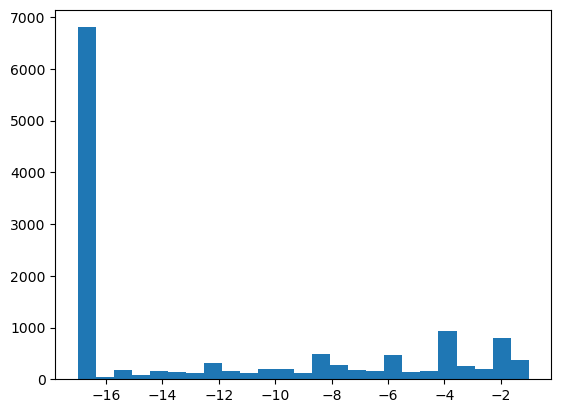

In [281]:
closeness = 1 - match_probabilities[match_probabilities > .9]
closeness[closeness == 0] = 1e-17
counts, bins, _ = plt.hist(np.log10(closeness), bins=25)

In [282]:
px.line(y=counts.cumsum(), x=bins[1:])

In [24]:
counts = []
for threshold in [1 - 10 ** power for power in bins[1:]]:
    counts.append(Counter([len(matches) for matches in find_matches(threshold, new_match_probabilities).values()]))

In [25]:
px.line(y=[counter[2] for counter in counts], x=bins[1:])

### Multi

In [95]:
multi_matches = {k: v for k, v in caselist_tabroom_matches.items() if len(v) > 1}
caselist_data_by_team.loc[list(multi_matches.keys())]

side      tournament round          opponent             judge  \
teamId roundId                                                                  
48596  566946     N   CSU Fullerton     2  Weber State ShSh       Jim Schultz   
       566940     N           KCKCC     2        MoState GR     Zach Simonson   
       566939     A             USC     1        Harvard HK      Omar Guevara   
       566938     A           KCKCC     4        MoState CR      Sean Kennedy   
       566944     N  CSU Fullterton     5     Pepperdine CS  Armands Revelins   
...             ...             ...   ...               ...               ...   
77594  913403     A              UK     5          Solon WH      Charlie Synn   
       913399     A             yuh     1               yuh               yuh   
       913404     A              UK     6   College Prep HP      Joanne Zhang   
       913411     N           yuh 2     2             yuh 2             yuh 2   
       913402     A              UK     4          Blair CW         Ronak Pai   

                                                           report  \
teamId roundId                                                      
48596  566946   1AC Feminist Theology\n1NC Womanist Theology A...   
       566940   1AC Organ Sales\n1NC Neolib Bad some case turn...   
       566939                                   1AC - Death Poems   
       566938   Legalize online prediction markets \nPredictio...   
       566944   1AC Swedish Model\n1NC Queerness Case Turns\n2...   
...                                                           ...   
77594  913403   1AC NATO and Deterrence\n1NC oil and retal\n2A...   
       913399                                                       
       913404   1AC NATO and Deterrence\n1NC oil populism and ...   
       913411                                                       
       913402   1AC NATO and Deterrence\n1NC Cyber and NATO\n2...   

               opensourcePath caselistUpdatedAt teamName teamDisplayName  \
teamId roundId                                                             
48596  566946            None              None     PiWr       Iowa PiWr   
       566940            None              None     PiWr       Iowa PiWr   
       566939            None              None     PiWr       Iowa PiWr   
       566938            None              None     PiWr       Iowa PiWr   
       566944            None              None     PiWr       Iowa PiWr   
...                       ...               ...      ...             ...   
77594  913403            None              None     PaWa    Sidwell PaWa   
       913399            None              None     PaWa    Sidwell PaWa   
       913404            None              None     PaWa    Sidwell PaWa   
       913411            None              None     PaWa    Sidwell PaWa   
       913402            None              None     PaWa    Sidwell PaWa   

               notes debater1First debater1Last debater2First debater2Last  \
teamId roundId                                                               
48596  566946   None       Ma.....      Pi.....       He.....      Wr.....   
       566940   None       Ma.....      Pi.....       He.....      Wr.....   
       566939   None       Ma.....      Pi.....       He.....      Wr.....   
       566938   None       Ma.....      Pi.....       He.....      Wr.....   
       566944   None       Ma.....      Pi.....       He.....      Wr.....   
...              ...           ...          ...           ...          ...   
77594  913403   None       As.....      Pa.....       Se.....      Wa.....   
       913399   None       As.....      Pa.....       Se.....      Wa.....   
       913404   None       As.....      Pa.....       Se.....      Wa.....   
       913411   None       As.....      Pa.....       Se.....      Wa.....   
       913402   None       As.....      Pa.....       Se.....      Wa.....   

                schoolId schoolName schoolDisplayName state

In [96]:
multi_team_dfs = {}
with tabEngine.connect() as conn:
    for caselist_id, tabroom_ids in multi_matches.items():
        multi_team_query = select(team_table.c.id, team_table.c.debater1, team_table.c.debater2, entry_table.c.id, entry_table.c.code, entry_table.c.name, entry_table.c.school_name, entry_table.c.school_code, tournament_table.c.name, tournament_table.c.season)\
            .select_from(
                team_table\
                    .join(entry_table, team_table.c.id == entry_table.c.team)\
                    .join(event_table, entry_table.c.event == event_table.c.id)\
                    .join(category_table, event_table.c.category == category_table.c.id)\
                    .join(tournament_table, category_table.c.tournament == tournament_table.c.id)
            )\
            .where(entry_table.c.team.in_(tabroom_ids))
        result = pd.read_sql(multi_team_query, conn)
        multi_team_dfs[caselist_id] = result[result.season == caselist_team_data.loc[caselist_id].year]
multi_team_data = pd.concat(multi_team_dfs)
multi_team_data

id  debater1 debater2     id_1                    code  \
48596 0    11026    203442   204124   595058                 Iowa PO   
      1    11026    203442   204124   603454                 Iowa PW   
      2    16920    203440   203442   673678                 Iowa WP   
      3    16920    203440   203442   673689                 Iowa WP   
52158 0   172158    828377   828378  3019617               Baylor FH   
...          ...       ...      ...      ...                     ...   
76705 26  142519    421424   698131  2975995            Lakeville GN   
      27  142519    421424   698131  3010374            Lakeville GN   
      28  142519    421424   698131  3139992            Lakeville GN   
77594 6   141108    851542   851543  3818393            Sidwell WaPa   
      10  167548    948327   948328  3615585  Sidwell Independent PW   

                        name          school_name school_code  \
48596 0       Pilcher & Owen                 Iowa        Iowa   
      1     Wright & Pilcher                 Iowa        Iowa   
      2     Wright & Pilcher                 Iowa        Iowa   
      3     Wright & Pilcher                 Iowa        Iowa   
52158 0    Feinauer & Hudson               Baylor      Baylor   
...                      ...                  ...         ...   
76705 26  Gerlach & Nomeland            Lakeville      Lakevi   
      27  Gerlach & Nomeland            Lakeville      Lakevi   
      28  Gerlach & Nomeland            Lakeville      Lakevi   
77594 6     Wallace & Pareek                 None        None   
      10    Pareek & Wallace  Sidwell Independent      SidInd   

                                                     name_1  season  
48596 0               2014 UMKC Baby Jo Memorial Tournament    2014  
      1                            KCKCC Blue Devil Debates    2014  
      2             2015 USC Alan Nichols Debate Tournament    2014  
      3           2015 Kathryn Klassic  Cal State Fullerton    2014  
52158 0              3rd Annual Phyllis Schatz Invitational    2020  
...                                                     ...     ...  
76705 26                      Jack Howe Memorial Tournament    2020  
      27      Florida Blue Key Speech and Debate Tournament    2020  
      28  John Edie Holiday Debates Hosted by The Blake ...    2020  
77594 6             Glenbrooks Speech and Debate Tournament    2021  
      10  National Speech and Debate Season Opener hoste...    2021  

[753 rows x 10 columns]

In [42]:
counts.loc[list(multi_matches.keys())]

judge       opponent      
             matches total  matches total
48596 16920        6    10        5    10
      11026        3    10        4    10
52158 199696       0     6        0     8
      193956       0     6        0     8
      179916       2     6        4     8
...              ...   ...      ...   ...
76705 130904      14    23       24    33
      142519       9    23        9    33
77594 167548       6    12        6    11
      141108       4    12        5    11
      172351       0    12        0    11

[378 rows x 4 columns]

## Tests

### Misc

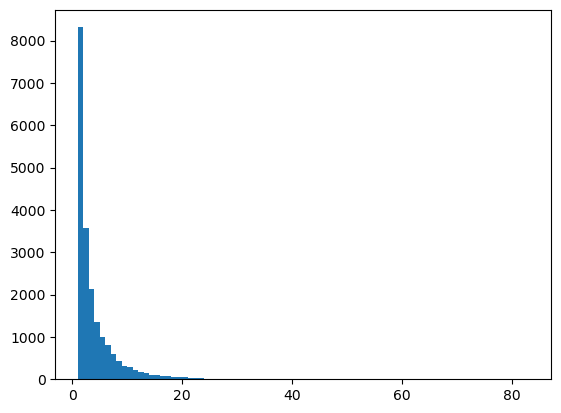

In [237]:
data = match_probabilities.groupby(level=0).size()
counts, bins, _ = plt.hist(data, bins=np.arange(min(data), max(data)))

In [264]:
match_probabilities.groupby(level=0).mean()

48357    0.500000
48358    0.333339
48359    0.250006
48360    1.000000
48361    0.206810
           ...   
79252    0.004600
79253    1.000000
79254    0.333333
79255    1.000000
79256    1.000000
Length: 20172, dtype: float64

In [270]:
px.line(data[data<30].groupby(data).apply(lambda x: match_probabilities.loc[x.index].mean()))

In [81]:
data = pd.DataFrame(dict(
    judges=[(team.total_judges / team.total_rounds) for team in caselist_tab_map.values()],
    opponents=[(team.total_opponents / team.total_rounds) for team in caselist_tab_map.values()],
))
px.histogram(data, barmode='overlay')

In [236]:
px.histogram(pd.DataFrame(dict(
    rounds=[team.total_rounds for team in caselist_tab_map.values()],
    judges=[team.total_judges for team in caselist_tab_map.values()],
    opponents=[team.total_opponents for team in caselist_tab_map.values()]
)), barmode='overlay', histnorm='probability')

### Rounds

In [103]:
caselist_id, tmp = list(caselist_tabroom_matches.items())[2000]
tabroom_id = tmp[0]
caselist_team = caselist_tab_map[caselist_id]
caselist_team.caselist_single_judges

[('jon williamson', '5', 'N'),
 ('donny peters', '3', 'N'),
 ('aditya limaye', '3', 'N'),
 ('lee thach', '2', 'N'),
 ('josh martin', '5', 'A'),
 ('sarah lim', '4', 'N'),
 ('kevin attiyeh', '6', 'N'),
 ('nathaniel haas', '3', 'A'),
 ('joel su', '4', 'A'),
 ('forrest fulgenzi', '1', 'A'),
 ('scott wheeler', '1', 'A'),
 ('eric oddo', '2', 'N'),
 ('scott phillips', '2', 'A'),
 ('nathan tribble', '6', 'N'),
 ('adam smiley', '5', 'A'),
 ('brandon dixon', '6', 'A'),
 ('josh martin', '5', 'N'),
 ('donny peters', '3', 'A'),
 ('wyllene turner', '4', 'N'),
 ('bill wilson', '6', 'A'),
 ('tom vavra', '2', 'N'),
 ('eric beane', '1', 'A'),
 ('cj morton', '3', 'A'),
 ('sean thai', '5', 'N'),
 ('steve wimsatt', '1', 'A'),
 ('tom woodhead', '4', 'A'),
 ('nathan rothenbaum', '2', 'N')]

In [46]:
# tabroom_id = caselist_tabroom_matches[caselist_team.caselist_id][0]
# tabroom_judges = caselist_team.tabroom_judges[tabroom_id]
# def process_tournament(tournament_rounds: pd.DataFrame):
#     tabroom_tournament_counts = Counter()
#
#     caselist_judges = caselist_team.get_judge_data(tournament_rounds)
#     tabroom_judges = caselist_team.tabroom_judges[tabroom_id]
#     for caselist_judge in caselist_judges:
#         if caselist_judge not in tabroom_judges: continue
#         for tournament_id in tabroom_judges[caselist_judge]:
#             tabroom_tournament_counts[tournament_id] += 1
#
#     caselist_opponents = caselist_team.get_opponent_data(tournament_rounds)
#     tabroom_opponents = caselist_team.tabroom_opponent_codes[tabroom_id]
#     for caselist_opponent in caselist_opponents:
#         if caselist_opponent not in tabroom_opponents: continue
#         for tournament_id in tabroom_opponents[caselist_opponent]:
#             tabroom_tournament_counts[tournament_id] += 1
#
#     return tabroom_tournament_counts
#
# tournament_counts = caselist_team.rounds.groupby('tournament').apply(process_tournament)
# tournament_count_maxes = tournament_counts.groupby(level=0)\
#     .apply(lambda d: d.values[0].most_common()[0][0] if d.values[0] else None)
# tournament_count_maxes

tournament
1 ERRDAY                                                                   NaN
CSU Fullerton                                                           2884.0
Cal Berkeley                                                            3024.0
Golden Desert                                                           3550.0
Information                                                                NaN
La Costa Canyon                                                         3326.0
Notre Dame                                                              2820.0
San Diego Winter Classic  La Costa                                      3326.0
San Diego Winter Classic La Costa                                       3326.0
The Prestigious California High School Speech Association Tournament       NaN
dtype: float64

In [29]:
# for name, group in caselist_team.rounds.groupby('tournament'):
#     break

In [30]:
# caselist_judges = caselist_team.get_judge_data(group)
# caselist_opponents = caselist_team.get_opponent_data(group)
#
# tabroom_judges = caselist_team.tabroom_judges[caselist_team.tabroom_id]
# tabroom_opponents = caselist_team.tabroom_opponent_codes[caselist_team.tabroom_id]

In [46]:
# caselist_judge_matches = {}
# for caselist_judge in caselist_judges:
#     if caselist_judge not in tabroom_judges: continue
#     for tabroom_ids in tabroom_judges[caselist_judge]:
#         if caselist_judge not in caselist_judge_matches: caselist_judge_matches[caselist_judge] = [tabroom_ids]
#         else: caselist_judge_matches[caselist_judge].append(tabroom_ids)
#
# caselist_opponent_matches = {}
# for caselist_opponent in caselist_opponents:
#     if caselist_opponent not in tabroom_opponents: continue
#     for tabroom_ids in tabroom_opponents[caselist_opponent]:
#         if caselist_opponent not in caselist_opponent_matches: caselist_opponent_matches[caselist_opponent] = [tabroom_ids]
#         else: caselist_opponent_matches[caselist_opponent].append(tabroom_ids)
#
# tabroom_tournament_counts = Counter()
# for matches in caselist_judge_matches.values():
#     for tournament_id, _ in matches: tabroom_tournament_counts[tournament_id] += 1
# for matches in caselist_opponent_matches.values():
#     for tournament_id, _ in matches: tabroom_tournament_counts[tournament_id] += 1
# tournament_match = tabroom_tournament_counts.most_common(1)[0][0]

In [47]:
# tournament_rounds_query = select(section_table.c.id.label('section_id'), round_table.c.name, round_table.c.label)\
#     .select_from(
#         section_table \
#         .join(ballot_table, section_table.c.id == ballot_table.c.section) \
#         .join(entry_table, ballot_table.c.entry == entry_table.c.id) \
#         .join(team_table, entry_table.c.team == team_table.c.id) \
#         .join(round_table, section_table.c.round == round_table.c.id) \
#         .join(event_table, entry_table.c.event == event_table.c.id) \
#         .join(category_table, event_table.c.category == category_table.c.id) \
#         .join(tournament_table, category_table.c.tournament == tournament_table.c.id)
#     )\
#     .where(team_table.c.id == caselist_team.tabroom_id) \
#     .where(tournament_table.c.id == tournament_match)

In [48]:
# with tabEngine.begin() as con:
#     tournament_section_ids = {translate_tabroom_round_name(row['label'], row['name']): row['section_id'] for row in con.execute(tournament_rounds_query).mappings()}
# tournament_section_ids

{'2': 3198874,
 '1': 3198954,
 '3': 3199869,
 '4': 3200644,
 '5': 3202096,
 '6': 3207353,
 '7': 3210965}

In [49]:
# for (caselist_id, round_data), judge_data, opponent_data in zip(group.iterrows(), caselist_judges, caselist_opponents):
#     section_match_counts = Counter()
#     caselist_round_num = str
#     if round_data['round'] in tournament_section_ids:
#         section_match_counts[tournament_section_ids[round_data['round']]] += 1
#     if judge_data in caselist_judge_matches:
#         for _, section_id in caselist_judge_matches[judge_data]:
#             section_match_counts[section_id] += 1
#     if opponent_data in caselist_opponent_matches:
#         for _, section_id in caselist_opponent_matches[opponent_data]:
#             section_match_counts[section_id] +=1
#     round_matches[caselist_id] = section_match_counts.most_common(1)[0][0]

{704098: 3202096,
 704106: 3199869,
 704093: 3198874,
 704109: 3207353,
 704107: 3198954,
 704096: 3200644}

In [111]:
caselist_id, tmp = list(caselist_tabroom_matches.items())[2000]
tabroom_id = tmp[0]
caselist_team = caselist_tab_map[caselist_id]
with tabEngine.begin() as conn:
    caselist_team.find_round_matches(conn)
caselist_team.round_matches

{630079: 588803,
 630076: 586451,
 630077: 590626,
 630082: 590762,
 630089: 693832,
 630072: 697235,
 630091: 697387,
 630075: 583680,
 630064: 549730,
 630078: 590797,
 630068: None,
 630084: 549473,
 630085: 549909,
 630063: 549067,
 630066: 588208,
 630061: 546647,
 630062: 583660,
 630074: 548448,
 630058: 660807,
 630087: 663252,
 630067: 589467,
 630059: 662883,
 630080: None,
 630065: 612337,
 630086: 662601,
 630083: 612298,
 630060: 661603,
 630073: 612285,
 630071: 696574,
 630081: 612225,
 630069: 687283,
 630057: 612251,
 630090: 695706,
 630056: 612186,
 630055: None,
 630070: 694693,
 630088: 691671}

In [120]:
with tabEngine.begin() as conn:
    for team in tqdm(caselist_tab_map.values()):
        team.find_round_matches(conn)

  0%|          | 0/22294 [00:00<?, ?it/s]

In [220]:
dump_all(caselist_tab_map, 'caselist_tab_teams_round_matches')

#### Analyze Rounds

In [218]:
round_match_count = Counter()
matched_round_ids = set()
section_id_count = Counter()
section_matches = {}
caselist_matches = {}
for team in caselist_tab_map.values():
    for caselist_id, section_id in team.round_matches.items():
        round_match_count[section_id is not None] += 1
        if section_id is not None:
            matched_round_ids.add(caselist_id)
            section_id_count[section_id] += 1
            if section_id not in section_matches: section_matches[section_id] = []
            section_matches[section_id].append(caselist_id)
            caselist_matches[caselist_id] = section_id

round_match_count[True] / round_match_count.total()

0.5732852440740053

In [133]:
matched_rounds = caselist_data[caselist_data.roundId.isin(matched_round_ids)]
len(matched_rounds[matched_rounds.opensourcePath.notna()]) / len(caselist_data[caselist_data.opensourcePath.notna()])

0.6758433276567991

In [165]:
keys = section_matches[section_id_count.most_common()[3000][0]]
caselist_data_by_id.loc[keys]

,side,tournament,round,opponent,judge,report,opensourcePath,caselistUpdatedAt,teamId,teamName,teamDisplayName,notes,debater1First,debater1Last,debater2First,debater2Last,schoolId,schoolName,schoolDisplayName,state,chapterId,caselistId,caselistName,caselistDisplayName,year,event,level,teamSize,fileId,fileName,fileGid
roundId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
845008,N,Jack Howe,2,Presentation NB,Michael Harris,Same as last one,hsld19/MountainHouse/Vi/Mountain%20House-Victo...,None,72108,ImVi,Mountain House ImVi,None,Im.....,Vi.....,None,None,24232,MountainHouse,Mountain House,CA,NaN,1027,hsld19,HS LD 2019-20,2019,ld,hs,1,NaN,None,None
845009,N,Jack Howe,2,Presentation NB,Michael Harris,Same,hsld19/MountainHouse/Vi/Mountain%20House-Victo...,None,72108,ImVi,Mountain House ImVi,None,Im.....,Vi.....,None,None,24232,MountainHouse,Mountain House,CA,NaN,1027,hsld19,HS LD 2019-20,2019,ld,hs,1,93981.0,Mountain%20House-Victor-Neg-Jack%20Howe-Round2,BL_HZAQG
846737,A,Jack Howe,2,Mountain House IV,X,,None,None,72248,NiBo,Presentation NiBo,None,Ni.....,Bo.....,None,None,24277,Presentation,Presentation,CA,NaN,1027,hsld19,HS LD 2019-20,2019,ld,hs,1,NaN,None,None


In [176]:
team_counts = {}
for section_id, caselist_ids in tqdm(section_matches.items()):
    team_counts[section_id] = caselist_data_by_id.loc[caselist_ids].teamId.nunique()
team_counts

  0%|          | 0/131051 [00:00<?, ?it/s]

{568344: 1,
 568269: 1,
 568195: 2,
 496564: 1,
 495708: 1,
 495663: 1,
 568070: 2,
 496777: 1,
 496948: 1,
 495640: 2,
 495712: 1,
 496378: 1,
 496785: 1,
 496353: 1,
 497148: 1,
 495700: 2,
 495635: 1,
 496994: 1,
 497211: 1,
 495688: 1,
 495642: 2,
 496586: 1,
 508415: 1,
 507858: 1,
 509445: 1,
 509167: 1,
 508890: 1,
 508634: 1,
 700063: 1,
 700095: 1,
 672470: 1,
 509184: 1,
 612565: 1,
 508884: 1,
 507838: 1,
 508662: 1,
 674958: 2,
 612043: 1,
 507409: 1,
 675512: 1,
 611545: 1,
 673870: 1,
 610629: 1,
 611849: 1,
 673331: 1,
 610750: 1,
 700110: 1,
 667984: 1,
 643087: 1,
 637276: 2,
 637279: 2,
 641594: 1,
 568191: 1,
 790725: 1,
 568345: 1,
 495631: 1,
 568306: 1,
 568220: 1,
 614389: 1,
 568094: 1,
 496738: 1,
 567065: 1,
 791036: 1,
 612020: 1,
 567119: 1,
 567333: 1,
 612681: 1,
 567648: 2,
 614539: 1,
 495701: 1,
 790677: 1,
 790879: 2,
 790933: 1,
 790758: 1,
 496562: 2,
 496944: 2,
 736694: 1,
 497210: 1,
 667847: 1,
 567048: 1,
 672490: 1,
 495618: 1,
 790994: 1,
 790

In [178]:
team_count_counts = Counter(team_counts.values())
team_count_counts

Counter({1: 99550, 2: 31487, 3: 14})

In [201]:
round_match_dicts = {
    section_id: caselist_data_by_id.loc[caselist_ids]
    for section_id, caselist_ids in tqdm(section_matches.items())
}

  0%|          | 0/131051 [00:00<?, ?it/s]

In [202]:
round_match_data = pd.concat(round_match_dicts, axis=0)

In [205]:
multi_team_rounds = round_match_data.groupby(level=0).filter(lambda section: section.teamId.nunique() > 1)

In [207]:
(len(multi_team_rounds) / len(caselist_data_by_id),
 len(multi_team_rounds[multi_team_rounds.opensourcePath.notna()]) / len(caselist_data_by_id[caselist_data_by_id.opensourcePath.notna()]))

(0.22128911952857483, 0.29925721946447337)

In [209]:
multi_team_both_opensource = multi_team_rounds[multi_team_rounds.opensourcePath.notna()].groupby(level=0).filter(lambda section: section.teamId.nunique() > 1)
len(multi_team_both_opensource), len(multi_team_both_opensource) / len(caselist_data_by_id[caselist_data_by_id.opensourcePath.notna()])

(30684, 0.2223558824595094)

In [215]:
3513812 * .22235

781296.0982

In [227]:
with open('./data/caselist_round_matches.json', 'w') as f:
    json.dump({
        caselist_id: int(caselist_matches[caselist_id]) if caselist_id in caselist_matches else None
        for caselist_id in caselist_data.roundId
    }, f)
with open('./data/caselist_team_matches.json', 'w') as f:
    json.dump({
        str(caselist_team_id): caselist_tab_map[caselist_team_id].tabroom_id
        for caselist_team_id in caselist_data.teamId.unique()
    }, f)

### Misc

In [42]:
example = {
    (2, 'a', 1): ':)',
    (3, 'a', 4): [':o', ':D']
}
data_str = json.dumps([item for item in example.items()])
raw = json.loads(data_str)
{tuple(key): value for key, value in raw}

{(2, 'a', 1): ':)', (3, 'a', 4): [':o', ':D']}

In [45]:
(2, 'a', 2) not in example

True

In [ ]:
# list(caselist_tab_map.values())[0].matching_teams()

In [ ]:
with tabEngine.begin() as conn:
    caselist_tab_map[48393].find_judge_matches(conn)

In [82]:
caselist_tab_map[48393].caselist_id

48393

In [89]:
list(caselist_tab_map)[1001]

50030

In [116]:
with tabEngine.begin() as conn:
    a = CaselistTeam(48358).find_matches(conn)
a.judge_matches, a.opponent_matches

({4872: 4, 9722: 0, 10788: 0}, {4872: 4, 9722: 0, 10788: 0})

In [122]:
{int(k): {tuple(key): set(value) for key, value in team} for k, team in a.to_json()['tabroom_judges'].items()}

{4872: {('emily bosch', '1', 'N'): {2829},
  ('brian mcbride', '2', 'A'): {2829},
  ('marvin carter', '3', 'N'): {2829},
  ('risha bhattacharjee', '4', 'A'): {2829},
  ('ben crossan', '5', 'N'): {2829},
  ('ben dabiri', '6', 'A'): {2829},
  ('jackie massey', '7', 'N'): {2829},
  ('nicholas brady', '8', 'A'): {2829}},
 9722: {('sam lewis', '1', 'N'): {2857},
  ('shannen bazzi', '2', 'N'): {2857},
  ('lauren thomas', '3', 'A'): {2857},
  ('omair shahid', '4', 'N'): {2857},
  ('scott brown', '5', 'A'): {2857}},
 10788: {('bobby zhan', '1', 'A'): {2894},
  ('rohit rajan', '2', 'N'): {2894},
  ('zach harbauer', '3', 'N'): {2894},
  ('jack lassiter', '4', 'A'): {2894},
  ('david hingstman', '5', 'N'): {2894},
  ('bobby zhan', '6', 'A'): {2894}}}

In [125]:
CaselistTeam.from_json(a.to_json()).tabroom_judges

{4872: {('emily bosch', '1', 'N'): {2829},
  ('brian mcbride', '2', 'A'): {2829},
  ('marvin carter', '3', 'N'): {2829},
  ('risha bhattacharjee', '4', 'A'): {2829},
  ('ben crossan', '5', 'N'): {2829},
  ('ben dabiri', '6', 'A'): {2829},
  ('jackie massey', '7', 'N'): {2829},
  ('nicholas brady', '8', 'A'): {2829}},
 9722: {('sam lewis', '1', 'N'): {2857},
  ('shannen bazzi', '2', 'N'): {2857},
  ('lauren thomas', '3', 'A'): {2857},
  ('omair shahid', '4', 'N'): {2857},
  ('scott brown', '5', 'A'): {2857}},
 10788: {('bobby zhan', '1', 'A'): {2894},
  ('rohit rajan', '2', 'N'): {2894},
  ('zach harbauer', '3', 'N'): {2894},
  ('jack lassiter', '4', 'A'): {2894},
  ('david hingstman', '5', 'N'): {2894},
  ('bobby zhan', '6', 'A'): {2894}}}

In [ ]:
# Counter(len(team.candidate_ids) for team in caselist_tab_map.values()).most_common(7), Counter(len(team.candidate_ids) for team in old_caselist_tab_map.values()).most_common(7)

In [ ]:
caselist_data[caselist_data.fileName.notna() & (caselist_data.year != 2022) & (caselist_data.teamSize == 2)].teamId.nunique()

In [ ]:
7904-1636

In [ ]:
# ((judge_ratio >= 0.5).mean(), (judge_ratio >= 0.2).mean(), (judge_second_ratio <= 0.5).mean(), (judge_second_ratio <= 0.2).mean()), \
#     ((opponent_ratio >= 0.5).mean(), (opponent_ratio >= 0.75).mean(), (opponent_second_ratio <= 0.75).mean(), (opponent_second_ratio <= 0.5).mean())

In [ ]:
# judge_match = judge_ratio > 0.2
# opponent_match = opponent_ratio > 0.75
# (judge_match.mean(), opponent_match.mean()), (judge_match + opponent_match).mean(), (judge_match * opponent_match).mean(), (judge_match ^ opponent_match).mean()

In [ ]:
only_match = np.array([info.only for info in caselist_tab_map.values()])
only_match.mean()

In [ ]:
# missing = [values[i]['teamId'] for i, found in enumerate(judge_ratio < 0.5) if not found]
# missing_data = caselist_data[caselist_data.teamId.isin(missing)]
# missing_data[(missing_data.year == 2018) & (missing_data.level == 'hs')]

In [ ]:
def plot_gte(nums):
    counts = pd.Series(nums).value_counts()
    sums = np.cumsum(counts.sort_index()[::-1])[::-1]
    plt.plot(sums)
    plt.scatter(sums.index, sums)
    return sums

In [ ]:
# np.argmax(judge_ratio * np.array([info['total'] for info in values]))

In [ ]:
# plt.hist([judge_ratio, opponent_ratio])

In [ ]:
plt.xlim(0, 20)
pd.DataFrame({
    'judge': plot_gte([info.total_judges for info in caselist_tab_map.values()]),
    'opponent': plot_gte([info.total_opponents for info in caselist_tab_map.values()])
})

In [ ]:
pd.Series([len(s) for s in team_code_sets.values()]).value_counts() / len(team_code_sets)

In [ ]:
# only_missing_ids = [
#     (teamId, data.only_id)
#     for i, (teamId, data) in enumerate(caselist_tab_map.items())
#     if data.only and judge_ratio[i] < 0.2
# ]

In [ ]:
# caselist_ids = [data[0] for data in only_missing_ids]
# tabroom_ids = [data[1] for data in only_missing_ids]
#
# only_missing_data = caselist_team_data.loc[caselist_ids].teamDisplayName.reset_index()
# only_missing_data['tabroomId'] = pd.Series(tabroom_ids)
# only_missing_data

In [ ]:
# tabroom_names = []
# with tabEngine.begin() as conn:
#     for i, tab_team_id in enumerate(tqdm(tabroom_ids)):
#         q = entry_table\
#                 .join(team_table, team_table.c.id == entry_table.c.team)\
#                 .select().where(team_table.c.id == tab_team_id)
#         tabroom_names.append(conn.execute(q).mappings().first()['code'])

In [ ]:
# only_missing_data['tabroomName'] = pd.Series(tabroom_names)
# only_missing_data

In [ ]:
# weak_matched = judge_match + opponent_match + only_match
# strong_matched = (judge_match.astype(int) + opponent_match.astype(int) + only_match.astype(int)) >= 2
# weak_matched.mean(), strong_matched.mean()

In [ ]:
# matched = strong_matched
# matched_info = [values[i] for i, is_match in enumerate(matched) if is_match]
# matched_caselist_ids = [info.caselist_id for info in matched_info]

In [ ]:
# matched_school_ids = set(caselist_team_data.loc[matched_caselist_ids].schoolId)
# matched_school_teams = caselist_team_data[caselist_team_data.schoolId.isin(matched_school_ids)]
# len(matched_caselist_ids) / len(caselist_team_data), len(matched_school_teams) / len(caselist_team_data)

In [ ]:
plt.plot(len(caselist_team_data) - np.cumsum(caselist_data.teamId.value_counts().value_counts().sort_index()))
plt.xlim(0, 50)
plt.ylim(0)

In [ ]:
caselist_team_data.schoolId.value_counts().value_counts()

In [ ]:
tournament_counts = caselist_data.groupby('teamId').tournament.aggregate(lambda t: t.nunique())

In [ ]:
plt.xlim(0, 20)
plot_gte(tournament_counts)

In [ ]:
caselist_data[caselist_data.fileName.notna()].teamId.nunique() / caselist_data.teamId.nunique()

In [ ]:
name_counts = caselist_data[caselist_data.full_names.notna()].groupby('teamId').full_names.nunique()
caselist_data[caselist_data.teamId.isin(name_counts[name_counts > 1].index) & (caselist_data.year != 2022) & (caselist_data.teamSize > 1)].set_index(['teamId', 'roundId'])

In [ ]:
# ### Match Counts
# JUDGE_THRESHOLD = {'high': 0.5, 'low': 0.1}
# OPPONENT_THRESHOLD = {'high': 0.5, 'low': 0.2}
# caselist_matches: dict[int, list[int]] = {
#     team_id: caselist_team.matching_teams() for team_id, caselist_team in caselist_tab_map.items()
# }
# matched_teams = [(caselist_id, tabroom_id) for caselist_id, tabroom_ids in caselist_matches.items() for tabroom_id in
#                  tabroom_ids]
# tabroom_matches: dict[int, dict[int, set]] = {}
# for caselist, tabroom in matched_teams:
#     if not tabroom in tabroom_matches: tabroom_matches[tabroom] = {}
#     info = tabroom_matches[tabroom]
#     year = caselist_team_data.loc[caselist].year
#     if year not in info: info[year] = set()
#     info[year].add(caselist)
# caselist_counts = Counter(len(matches) for matches in caselist_matches.values())
# tabroom_counts = Counter(len(matches) for years in tabroom_matches.values() for matches in years.values())
# (
#     caselist_counts, caselist_counts[1] / len(caselist_matches),
#     100 * (len(caselist_matches) - caselist_counts[0] - caselist_counts[1]) / len(caselist_matches),
#     tabroom_counts, 100 * (sum(tabroom_counts.values()) - tabroom_counts[1]) / sum(tabroom_counts.values())
# )

#### Judge

In [324]:
def parse_judge_name(judge_name: str):
    if re.match(r'\w+ \w+', judge_name):
        return re.sub(r'[^\s\w]', '', judge_name).lower()
    if re.match(r'((\w+), )+', judge_name):
        sections = sorted(judge_name.split(', '))
        return re.sub(r'[^\s\w,]', '', ', '.join(sections)).lower()
    return False
round = caselist_data.iloc[1005]
parse_judge_name(round.judge), round

('asafuadjaye, henry, lee',
 roundId                                                           623882
 side                                                                   N
 tournament                                                   3 - Harvard
 round                                                            Doubles
 opponent                                                        Texas DK
 judge                                           Henry, Asafu-Adjaye, Lee
 report                 1AC\n-Logistics\n1NC\n-T-USFG\n-Antidomination...
 opensourcePath         ndtceda21/Georgetown/AnGr/Georgetown-Anderson-...
 caselistUpdatedAt                                                   None
 teamId                                                             52652
 teamName                                                            AnGr
 teamDisplayName                                          Georgetown AnGr
 notes                                                               None
 debater1F

In [326]:
tabroom_id = caselist_tabroom_matches[round.teamId][0]


141613

In [317]:
tmp = caselist_data.judge

In [322]:
i=1000
tmp.iloc[i:i+20]

14114                 Julia Henry
14115                   Amar Adam
14116             Miriam Mokhemar
14117               Darcell Brown
14118               Brian Klarman
14119    Henry, Asafu-Adjaye, Lee
14120      David Michael Woodward
14121                  Young Kwon
14122                 Julia Henry
14123                  Will Repko
14124                 Ben Morbeck
14125                      Dallas
14126              Brandon Kelley
14127              Michael Barlow
14128                Amber Kelsie
14129                   Joe Skoog
14130                Sammi Riptoe
14131             Clayton Engelby
14132                  Josh Lamet
14133    Cerja, Mollison, Astacio
Name: judge, dtype: object

## Analyze teams

In [ ]:
team_counts = Counter({k: len(v) for k, v in team_code_sets.items()})
team_counts.most_common(100)

In [ ]:
team_codes: dict[int, set[str]] = {}
for code, teams in team_code_sets.items():
    for team_id in teams:
        if not team_id in team_codes: team_codes[team_id] = set()
        team_codes[team_id].add(code)

In [ ]:
team_code_counts = Counter({team: len(codes) for team, codes in team_codes.items()})

In [ ]:
(np.array(list(team_code_counts.values())) ** 2).mean(), (np.array(list(team_counts.values())) ** 2).mean()

In [ ]:
caselist_data['round'].value_counts()

In [ ]:
(caselist_data['round'].value_counts() ** 2).sum() / (caselist_data['round'].value_counts().sum()) ** 2

In [ ]:
(caselist_data['round'].str.len() > 1).sum() / len(caselist_data)

In [ ]:
with tabEngine.begin() as conn:
    labels = pd.read_sql(
        text("""
            select r.label, count(*) as count from section
            join round r on section.round = r.id
            group by r.label order by count desc;
        """), conn
    )
labels

In [ ]:
pd.DataFrame({
    'label': labels.label,
    'translated': labels.label.apply(lambda l: translate_tabroom_round_name(l, 999)),
    'count': labels['count'],
})

In [ ]:
# matched_judge_scores = [
#     caselist_tab_map[caselist_id].judge_matches[matches[0]] / caselist_tab_map[caselist_id].total_judges
#     for caselist_id, matches in caselist_matches.items()
#     if len(matches) and caselist_tab_map[caselist_id].total_judges
# ]
# px.histogram(matched_judge_scores)
# match_fractions = [matches / caselist_team.total_judges for caselist_team in caselist_tab_map.values() if
#                    caselist_team.total_judges for matches in caselist_team.judge_matches.values()]
# print(np.array(match_fractions).mean())
# px.histogram(match_fractions, nbins=20)
# px.histogram([len(team.candidate_ids) for team in caselist_tab_map.values()])
# np.array(matched_judge_scores).mean()

### Multi
# multi_matches = {}
# for tabroom_id in tabroom_matches:
#     multi_matches = multi_matches | {(tabroom_id, year): matches for year, matches in
#                                      tabroom_matches[tabroom_id].items() if len(matches) > 1}
# multi_matches
# real_multi_match = []
# for tabroom_info, caselist_ids in multi_matches.items():
#     team_data = caselist_team_data.loc[list(caselist_ids)]
#     if team_data.schoolId.nunique() > 1 and team_data.caselistId.nunique() == 1:
#         print(tabroom_info, caselist_ids)
#         real_multi_match.append(tabroom_info)
# tabroom_id, year = real_multi_match[1]
# print(tabroom_id, tabroom_matches[tabroom_id][year])
# caselist_data[caselist_data.teamId.isin(tabroom_matches[tabroom_id][year])]
# ### Schools
# matched = [caselist_id for caselist_id in caselist_matches if caselist_matches[caselist_id]]
# matched_school_ids = set(caselist_team_data.loc[matched].schoolId)
# matched_school_teams = caselist_team_data[caselist_team_data.schoolId.isin(matched_school_ids)]
# len(matched) / len(caselist_team_data), len(matched_school_teams) / len(caselist_team_data)
# names = caselist_team_data.schoolShortName.drop_duplicates()
# with tabEngine.begin() as conn:
#     names_exist = pd.DataFrame({
#         'names': names,
#         'exists': names.apply(
#             lambda name: conn.execute(select(exists().where(entry_table.c.school_code == name))).first()[0])
#     }).set_index('names').exists
# print(names_exist.mean())
# names_exist
# matched_school_names = caselist_team_data.loc[matched].schoolShortName
# names_exist.loc[list(matched_school_names)].mean()
# caselist_data.schoolShortName.isna().mean()
# from random import random
#
# matches_school: dict[int, bool] = {}
# no_tab_id = []
# with tabEngine.begin() as conn:
#     for caselist_id, tabroom_ids in tqdm(caselist_matches.items()):
#         if not tabroom_ids: continue
#         tabroom_id = tabroom_ids[0]  # ignore multiple for now
#         caselist_school_code = caselist_team_data.loc[caselist_id].schoolShortName
#         school_codes_q = select(entry_table.c.school_code).distinct().where(entry_table.c.team == tabroom_id)
#         tabroom_school_codes = [row[0] for row in conn.execute(school_codes_q)]
#         if not any(tabroom_school_codes):
#             no_tab_id.append(caselist_id)
#         else:
#             matches_school[caselist_id] = caselist_school_code in tabroom_school_codes
# matches_school_list = list(matches_school.values())
# sum(matches_school_list) / len(matches_school_list), len(no_tab_id)

In [178]:
# tabroom_caselist_names: dict[str, set[str]] = {}
# for caselist_name, tabroom_names in school_tabroom_names.items():
#     for name in tabroom_names:
#         if name not in tabroom_caselist_names: tabroom_caselist_names[name] = {caselist_name}
#         else: tabroom_caselist_names[name].add(caselist_name)
# sorted(tabroom_caselist_names.items(), key=lambda x: len(x[1]), reverse=True)[:20]
#
# with tabEngine.begin() as conn:
#     caselist_team = caselist_tab_map[list(caselist_tabroom_matches.keys())[2000]]
#     # caselist_team = caselist_tab_map[48358]
#     caselist_team = CaselistTeam.from_json(caselist_team.to_json()).find_matches(conn)
#     team_tabroom_school_names = school_tabroom_names[caselist_team.caselist_school_name]
#     matches = caselist_team.find_school_matches(team_tabroom_school_names, conn)
# matches, caselist_team.candidate_school_names

({5261: True, 9879: False},
 {5261: {'Chaminade', 'Chaminade CP'}, 9879: {'Aquarius'}})

In [ ]:
# loaded = list(caselist_tab_map.values())
# with tabEngine.begin() as conn:
#     %lprun -f CaselistTeam.match -f CaselistTeam.find_judge_matches -f CaselistTeam.find_opponent_matches [CaselistTeam(loaded[i].caselist_id).match(conn) for i in range(100)]

In [ ]:
# %lprun -f CaselistTeam.__init__ [CaselistTeam(loaded[i].caselist_id) for i in range(1000)]

In [ ]:
# with open('./data/caselist_tab_judge_info_old3.json', 'r') as f:
#     old_caselist_tab_map: dict[int, CaselistTeam] = {int(k): CaselistTeam.from_json(v) for k,v in tqdm(json.load(f).items())}